**Instructors**: Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Jiazhi Li (jiazhil@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and Prof. Keith Chugg (chugg@usc.edu). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from matplotlib import colors
from autograd import grad 
from autograd import hessian
readDataPath = './readData/'

In [4]:
## This code cell will not be shown in the HTML version of this notebook
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w, data, labels, inputs_flag = False):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        if (inputs_flag == True):
            cost_eval,grad_eval = gradient(w,data,labels)
        else:
            cost_eval,grad_eval = gradient(w)
            
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    ###########weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    #if (inputs_flag == True):
        #cost_history.append(g(w,data,labels))
    #else:
        #cost_history.append(g(w))  
    return weight_history,cost_history

In [5]:
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [6]:
def sigmoid(t):
    return 1/(1 + np.exp(-t))

def cross_entropy(w,x,y):
    a = sigmoid(model(x,w))
    ind = np.argwhere(y == 0)[:,1]
    cost = -np.sum(np.log(1 - a[:,ind]))
    ind = np.argwhere(y==1)[:,1]
    cost -= np.sum(np.log(a[:,ind]))
    return cost/y.size

In [7]:
def model_prediction(x_p,w):
    a = w[0] + np.dot(x_p.T,w[1:])
    predictions = [sigmoid(l) for l in a]
    return predictions

In [8]:
def plot_contour_decision(w,x,y):
    r_min = -15; r_max = 15
    x_contour = np.arange(r_min, r_max, 0.1)
    y_contour = np.arange(r_min, r_max, 0.1)
    xx, yy = np.meshgrid(x_contour, y_contour)
    X_pred = np.c_[xx.ravel(), yy.ravel()]
    y_line = np.asarray(model_prediction(X_pred.T,w))
    plt.figure(figsize=(7, 7))
    contour_labels = y_line.reshape(xx.shape)
    cmap = colors.ListedColormap(['blue', 'red'])
    col = np.where(y.flatten()==1,'r','b')
    plt.scatter(x[0,:],x[1,:], c = col, s=100)
    plt.xlabel('X1', fontsize = 12)
    plt.ylabel('X2', fontsize = 12)
    r = np.arange(r_min,r_max,0.1)
    z = - w[0]/w[2] - w[1]/w[2]*r
    plt.plot(r,z,linewidth = 2.75,color = 'k',zorder = 2)
    plt.show()

In [9]:
def generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal', quiet_mode='true'):
    """
    means: shape (2, 2), means[0] is the 2 x 1 mean vector for class 1 data generation
    lambdas: shape (2, 2), lambdas[0] are the 2 eigenvalues of the covariance matrix for generatinge data for class 1
    Ns: [N1, N2] the number of samples to be generated for each of teh two classes.
    distribution: in {normal, exponential, uniform} sets the distribution to generate data for both classes.
    quiet_mode: added this so that it won't print the details unless quiet_mode == False
    """
    N1 = Ns[0]
    N2 =  Ns[1]
    N = N1 + N2
    x = np.zeros((N, 2))
    assert distribution in {'normal', 'exponential', 'uniform'}, f'The {distribution} is not supported, only normal, exponential, uniform distributions are supported.'
    assert np.min(lambdas) > 0, f'lambda all have to be > 0 as they are variaces of the random vector projected onto the eigen-vectors.  You passed lambdas = {lambdas}'
    if distribution == 'normal':
        x[:N1] = np.random.normal(0, 1, (N1, 2))
        x[N1:] = np.random.normal(0, 1, (N2, 2))
    elif distribution == 'exponential':
        ## np.random.exponential(1) generates realizations from a unit variance, mean 1
        x[:N1] = np.random.exponential(1, (N1, 2)) - 1
        x[N1:] = np.random.exponential(1, (N2, 2)) - 1
    elif distribution == 'uniform':
        ## variance of uniform on (a,b) is (b-a)^2 / 12
        a = np.sqrt(3)
        x[:N1] = np.random.uniform(-a, a, (N1, 2))
        x[N1:] = np.random.uniform(-a, a, (N1, 2))

    def compute_coloring_matrix(theta, lams):
        E = np.asarray([ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)] ])
        Lambda_root = np.sqrt( np.asarray([ [lams[0], 0], [0, lams[1]] ]) )
        H = E @ Lambda_root
        K = H @ H.T
        return H, K

    H1, K1 = compute_coloring_matrix(thetas[0], lambdas[0])
    H2, K2 = compute_coloring_matrix(thetas[1], lambdas[1])

    x[:N1] = x[:N1] @ H1.T + means[0]
    x[N1:] = x[N1:] @ H2.T + means[1]

    labels = np.ones(N)
    labels[N1:] += 1

    sample_means = np.zeros((2,2))
    sample_means[0] = np.mean(x[:N1], axis=0)
    sample_means[1] = np.mean(x[N1:], axis=0)

    if not quiet_mode:
        print(f'Data generated under the {distribution} distribution')
        Ks = [K1, K2]
        Hs = [H1, H2]

        for i in range(2):
            print(f'The mean in the generating pdf for class {i + 1} is: {means[i]}')
            print(f'The sample mean for class {i + 1}  data is: {sample_means[i]}\n')

            print(f'The coloring matrix class {i + 1}  data is:\n {Hs[i]}')
            print(f'The covariance matrix class {i + 1}  data is:\n {Ks[i]}\n\n')

    return x, labels, sample_means

In [10]:
def create_animated_learning(x, labels, w_hats, cost_history, fname, display_interval=200):
    fig_to_animate, ax = plt.subplots(1, 2, sharex=False, figsize=(12, 6))
    ax[0].set_xlabel('x1', fontsize=12)
    ax[0].set_ylabel('x2', fontsize=12)
    ax[0].grid(':')
    LIMIT = abs(np.max(x))+4
    ax[0].set_xlim([-LIMIT, LIMIT])
    ax[0].set_ylim([-LIMIT, LIMIT])

    ax[1].set_ylabel(r'Cost Function $g$', color = 'green') 
    ax[1].tick_params(axis ='y', labelcolor = 'green') 
    ax[1].grid(':')
    def animate_plot(iteration):
        w_hat = w_hats[iteration]
        col = np.where(labels.flatten()==1,'r','b')
        ax[0].scatter(x[0,:],x[1,:], c = col, s=100)
        x_plot = np.arange(-LIMIT,LIMIT,0.1)
        z = - w_hat[0]/w_hat[2] - w_hat[1]/w_hat[2]*x_plot
        ax[0].plot(x_plot,z, alpha=0.5, label=f'iteration {iteration}')
        iterations = np.arange(iteration)
        ax[1].plot(iterations, cost_history[:iteration], marker='o', color='green', label=r'Cost Function $g$')
        ax[1].set_xlabel('')
    import matplotlib.animation as ani
    animator = ani.FuncAnimation(fig_to_animate, animate_plot, frames=np.arange(len(cost_history)), interval=display_interval)
    animator.save(fname)

In [11]:
means = np.asarray( [ [5, 0], [-5, 0] ])
lambdas = np.asarray( [ [30, 1], [30, 1] ])  
thetas = np.asarray([ np.pi / 4, np.pi / 4 ])
Ns = np.asarray([30, 30])
x_synthetic, labels_synthetic, sample_means = generate_colored_nongaussian_data(means, lambdas, thetas, Ns, distribution='normal')
labels = copy.deepcopy(labels_synthetic)
labels[labels==1] = 0
labels[labels==2] = 1

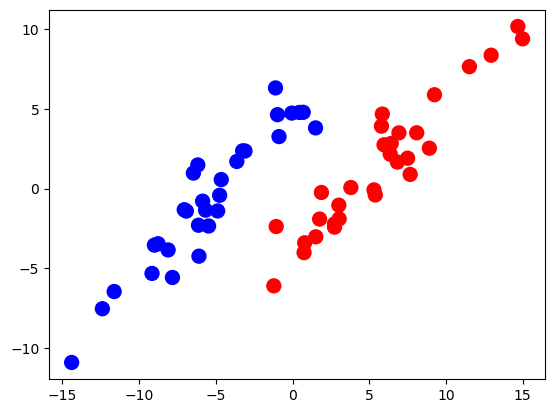

In [12]:
x = x_synthetic.T.copy()
y = labels.reshape(1,-1)
col = np.where(labels_synthetic.flatten()==1,'r','b')
plt.scatter(x[0,:],x[1,:], c = col, s=100)
plt.show()

In [13]:
g = cross_entropy; w = np.random.randn(3,1); max_its = 20; alpha_choice = 1;
weight_history_LogReg,cost_history_LogReg = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y, inputs_flag=True)

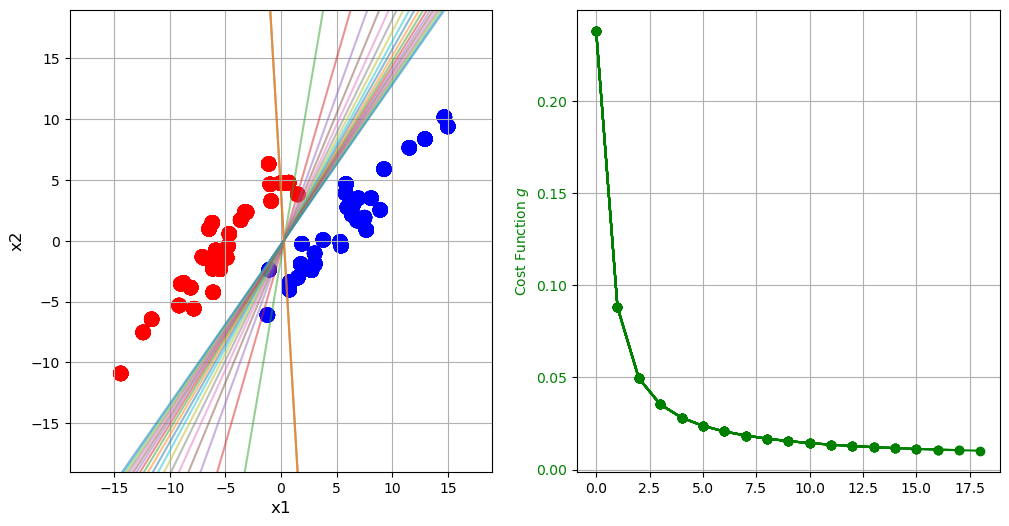

In [16]:
create_animated_learning(x, y.flatten(), weight_history_LogReg, cost_history_LogReg, 'img/LogReg.gif', display_interval=700)

In [17]:
def sigmoid_least_squares(w,x,y):
    a = w[0] + np.dot(x.T,w[1:])
    predictions = np.array([sigmoid(l) for l in a]).T
    cost = sum((predictions.flatten()-y.flatten())**2)
    return cost/y.size

In [18]:
g = sigmoid_least_squares; w = np.random.randn(3,1); max_its = 20; alpha_choice = 1;
weight_history_LeastSqSigmoid, cost_history_LeastSqSigmoid = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y, inputs_flag=True)

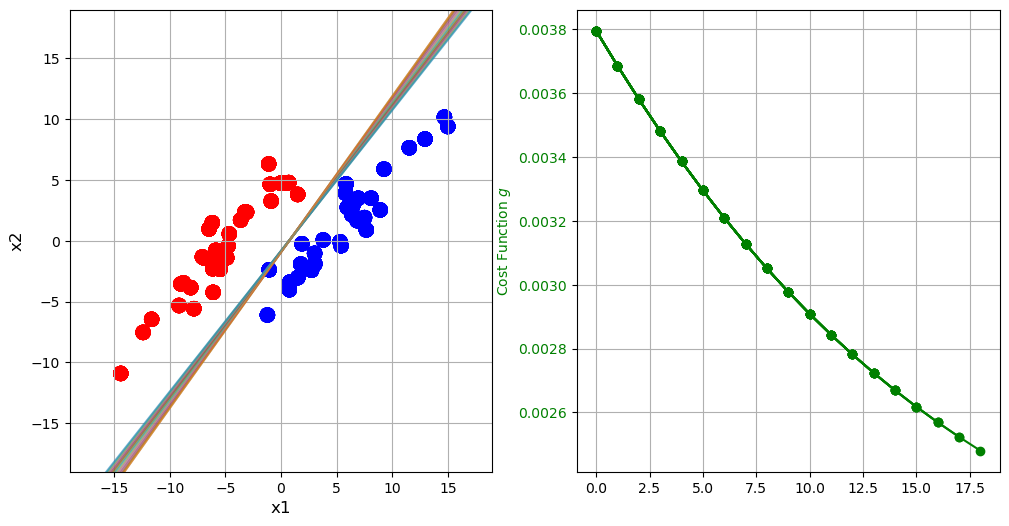

In [20]:
create_animated_learning(x, y.flatten(), weight_history_LeastSqSigmoid, cost_history_LeastSqSigmoid, 'img/LeastSqSigmoid.gif', display_interval=700)

In [21]:
def relu(w,x,y):
    a = w[0]+np.dot(x.T,w[1:])
    cost = np.sum(np.maximum(0,-y*a.T))
    return cost/float(np.size(y))

In [22]:
labels_Relu = copy.deepcopy(labels_synthetic)
labels_Relu[labels_Relu==1] = 1
labels_Relu[labels_Relu==2] = -1
y_RELU = labels_Relu.reshape(1,-1)

In [23]:
g = relu; w = np.random.randn(3,1); max_its = 20; alpha_choice = 1;
weight_history_PERCEPTRON,cost_history_PERCEPTRON = gradient_descent(g,alpha_choice,max_its,w, data = x, labels = y_RELU, inputs_flag=True)

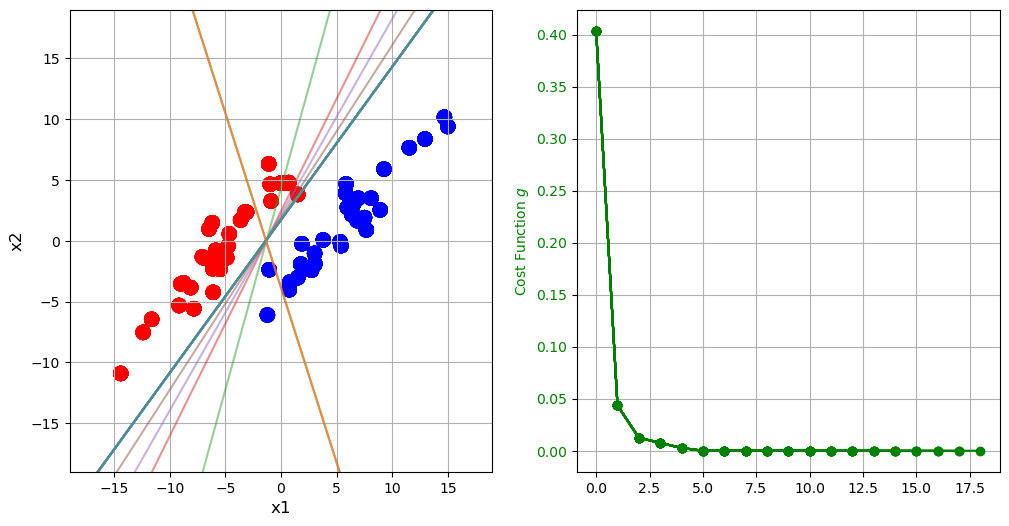

In [24]:
create_animated_learning(x, y.flatten(), weight_history_PERCEPTRON, cost_history_PERCEPTRON, 'img/PERCEPTRON.gif', display_interval=700)